17102022

Бруцкий-Стемпковский

v. 01


Подготовить данные для этапа моделирования (обучения)
    
1. Анализ данных, необходимые корректировки. 
2. Обработать пропуски. 
3. Оценить выбросы. 
4. Корреляция. 
5. Тест на нормальность распределения.
6. Масштабировать и стандартизировать данные.
7. Разделите данные на тренировачную и тестовую выборку.
8. При обработке пропусков/выбросов/скалировании тестовую и тренировачную выборку обрабатывать отдельно.

В данной версии самая проблемная колонка "regions" просто удалена.

Необходимые импорты библиотек.

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import pandas_profiling

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

Прочитаем фрейм. Переименуем колонки.

In [26]:
columns = [ 'id', 'gender', 'age', 
            'marital_status', 'job', 
            'sum_of_credit', 'credit_term',
            'tarrif_id', 'score_shk', 'edu', 
            'region', 'income', 'credit_count', 
            'overdue_credit_count', 'flag'
            ]
data = pd.read_csv('credit_train.csv', names=columns, skiprows=1, encoding='utf8', sep=';', decimal=",")
data.drop(columns=["id"], axis=1, inplace=True)
data.set_index(np.arange(len(data)), inplace=True)
data.head()

,gender,age,marital_status,job,sum_of_credit,credit_term,tarrif_id,score_shk,edu,region,income,credit_count,overdue_credit_count,flag
0,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


Проверим информацию о строках.

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job                   170746 non-null  object 
 4   sum_of_credit         170744 non-null  float64
 5   credit_term           170746 non-null  int64  
 6   tarrif_id             170746 non-null  object 
 7   score_shk             170739 non-null  float64
 8   edu                   170741 non-null  object 
 9   region                170554 non-null  object 
 10  income                170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  flag                  170746 non-null  int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 19.

Фрейм содержит 14 признаков. Как числовые, так и категориальные признаки. Целевой показатель (функция от всех остальных аргументов) зашит в последней колонке 'flag'.

Большое количество выбросов сдержится в категориях о количестве имеющихся непогашенных и просроченных кредитов. От выбросов в остальных колонка просто избавимся.

Можно было бы заменить значения отдельных столбцов на среднее для числовых значений (применим это для столбиков с кредитами), либо заменить на самое часто встречающееся для категориальных значений.

In [28]:
drop_columns = ['gender', 'age', 'marital_status', 'job', 'sum_of_credit', 'credit_term',
                'tarrif_id', 'score_shk', 'edu', 'income', 'flag']
data.dropna(subset=drop_columns, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170735 entries, 7 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170735 non-null  object 
 1   age                   170735 non-null  float64
 2   marital_status        170735 non-null  object 
 3   job                   170735 non-null  object 
 4   sum_of_credit         170735 non-null  float64
 5   credit_term           170735 non-null  int64  
 6   tarrif_id             170735 non-null  object 
 7   score_shk             170735 non-null  float64
 8   edu                   170735 non-null  object 
 9   region                170543 non-null  object 
 10  income                170735 non-null  float64
 11  credit_count          161505 non-null  float64
 12  overdue_credit_count  161505 non-null  float64
 13  flag                  170735 non-null  int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 19.

Было удалено ~200 записей, что вполне приемлемо при общем количестве в 170 000.

По результатам анализа видно следующее:

1. Колонки 'gender', 'age', 'marital_status', 'job', 'credit_term', 'tarrif_id', 'edu', 'income', 'flag'
очищены от испорченных данных. То есть их тип соотвествует ожидаемому, нет выбросов.

2. Колонки 'sum_of_credit' и 'score_shk' имеют большое число пропусков, но заменять пропуски мы будем после разбивки на тренировочоный и тестовый сеты.

3. Колонка 'region' имеет 301 уникальное значение, представляющее собой как строковые записи (повторяются по своей сути, но не по значению), встречаются числовые значения (74 и 98), вероятно представляющие собой номера регионов (Челябинск и Санкт-Петербург соответсвенно).

Удалим колонку "region"

In [29]:
data.drop(columns=["region"], inplace=True)

Теперь заполним пропуски для обеих выборок в колонках о количестве кредитов, заменив их на среднее значение.

In [30]:
data["credit_count"].fillna(data["credit_count"].mean(), inplace=True)
data["overdue_credit_count"].fillna(data["overdue_credit_count"].mean(), inplace=True)

Удалим выбросы.

In [31]:
#cleaning_cols = ["age", "sum_of_credit", "credit_term", "income", "credit_count", "overdue_credit_count"]   
#cleaning_cols = ["sum_of_credit", "credit_term", "income", "credit_count", "overdue_credit_count"]          
#cleaning_cols = ["age", "credit_term", "income", "credit_count", "overdue_credit_count"]                    
#cleaning_cols = ["age", "sum_of_credit", "income", "credit_count", "overdue_credit_count"]                  
#cleaning_cols = ["age", "sum_of_credit", "credit_term", "credit_count", "overdue_credit_count"]             
#cleaning_cols = ["age", "sum_of_credit", "credit_term", "income", "overdue_credit_count"]                   
#cleaning_cols = ["age", "sum_of_credit", "credit_term", "income", "credit_count"]                           

Наилучший результат приносит очистка от выбросов в колонках за исключением "sum_of_credit" и "overdue_credit_count"

In [32]:
cleaning_cols = ["age", "credit_term", "income", "credit_count"]                                            

In [33]:
for col in cleaning_cols:

    Q_1 = data[col].quantile(q = 0.25)
    Q_3 = data[col].quantile(q = 0.75)
    IQR = Q_3 - Q_1

    data = data.loc[~((data[col] < (Q_1-1.5*IQR))|(data[col] > (Q_3+1.5*IQR)))]

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137388 entries, 7 to 170745
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                137388 non-null  object 
 1   age                   137388 non-null  float64
 2   marital_status        137388 non-null  object 
 3   job                   137388 non-null  object 
 4   sum_of_credit         137388 non-null  float64
 5   credit_term           137388 non-null  int64  
 6   tarrif_id             137388 non-null  object 
 7   score_shk             137388 non-null  float64
 8   edu                   137388 non-null  object 
 9   income                137388 non-null  float64
 10  credit_count          137388 non-null  float64
 11  overdue_credit_count  137388 non-null  float64
 12  flag                  137388 non-null  int64  
dtypes: float64(6), int64(2), object(5)
memory usage: 14.7+ MB


Для наглядного анализа данных применим библиотеку Pandas_profiling.

In [35]:
#pandas_profiling.ProfileReport(data)

Для дальнейшего анализа кодируем категориальные значения в числовые с помощью метода get_dammies. Оставшиеся категориальные солбцы удаляем, вместо них появятся новые числовые столбцы.

In [36]:
data = pd.concat([  data, 
                    pd.get_dummies(data['gender'], prefix="gender"),
                    pd.get_dummies(data['marital_status'], prefix="marital_status"),
                    pd.get_dummies(data['job'], prefix="job"),
                    pd.get_dummies(data['edu'], prefix="edu")],
                    axis=1)
data.drop(["gender", "marital_status", "job", "edu"], axis=1, inplace=True)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137388 entries, 7 to 170745
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   137388 non-null  float64
 1   sum_of_credit         137388 non-null  float64
 2   credit_term           137388 non-null  int64  
 3   tarrif_id             137388 non-null  object 
 4   score_shk             137388 non-null  float64
 5   income                137388 non-null  float64
 6   credit_count          137388 non-null  float64
 7   overdue_credit_count  137388 non-null  float64
 8   flag                  137388 non-null  int64  
 9   gender_F              137388 non-null  uint8  
 10  gender_M              137388 non-null  uint8  
 11  marital_status_CIV    137388 non-null  uint8  
 12  marital_status_DIV    137388 non-null  uint8  
 13  marital_status_MAR    137388 non-null  uint8  
 14  marital_status_UNM    137388 non-null  uint8  
 15  

Тест Шапиро-Уилка. Тест на нормальность.

In [38]:
def normal_test(series):
    stat, p = sp.stats.shapiro(series)

    alpha = 0.05
    if p > alpha:
        return 'Похоже на нормальное распределение'
    else:
        return 'Не похоже на нормальное распределение'


Колонка tarrif_id почему-то вызывает исключение. Даже колонка score_shk не проходит тест на нормальность.

In [39]:
columns = ['age', 'sum_of_credit', 'credit_term', 'score_shk', 'income', 'credit_count', 'overdue_credit_count']

for name in columns:
    print(name, normal_test(data[name]))
    pass

age Не похоже на нормальное распределение
sum_of_credit Не похоже на нормальное распределение
credit_term Не похоже на нормальное распределение
score_shk Не похоже на нормальное распределение
income Не похоже на нормальное распределение
credit_count Не похоже на нормальное распределение
overdue_credit_count Не похоже на нормальное распределение


c:\Users\Николай\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [40]:
corr_matrix = data.corr();

C:\Users\Николай\AppData\Local\Temp\ipykernel_9100\1728945180.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr();


In [41]:
corr_matrix

,age,sum_of_credit,credit_term,score_shk,income,credit_count,overdue_credit_count,flag,gender_F,gender_M,...,job_SPC,job_UMN,job_WOI,job_WRK,job_WRP,edu_ACD,edu_GRD,edu_PGR,edu_SCH,edu_UGR
age,1.000000,-0.110642,-0.005843,-0.189733,-0.033735,0.098692,0.007676,-0.045972,0.125615,-0.125615,...,-0.140627,0.003241,-0.002870,-0.008614,0.038346,-0.003300,-0.058260,-0.007192,0.118988,-0.132913
sum_of_credit,-0.110642,1.000000,0.033212,0.066071,0.367451,-0.009364,-0.007026,-0.065961,-0.019599,0.019599,...,-0.053494,0.060663,-0.006387,-0.012087,-0.003883,0.004298,0.169275,0.009425,-0.185257,0.037759
credit_term,-0.005843,0.033212,1.000000,0.048597,0.000291,0.016568,0.012942,0.064321,-0.009119,0.009119,...,0.008448,-0.021059,0.010650,0.009111,0.005285,0.002897,-0.016528,0.009498,0.001245,0.030823
score_shk,-0.189733,0.066071,0.048597,1.000000,-0.090045,-0.111532,0.171684,0.048564,-0.001374,0.001374,...,0.028612,-0.042805,0.010767,0.025703,-0.003459,-0.005613,-0.251216,-0.019022,0.219593,0.066010
income,-0.033735,0.367451,0.000291,-0.090045,1.000000,0.129319,0.025998,-0.020446,-0.248032,0.248032,...,-0.113893,0.134280,-0.005843,-0.008551,-0.002824,0.009307,0.208972,0.028292,-0.225863,0.036749
credit_count,0.098692,-0.009364,0.016568,-0.111532,0.129319,1.000000,0.171590,0.028505,0.009561,-0.009561,...,-0.015345,0.023005,-0.004149,0.009433,0.003972,-0.000064,0.019883,0.009181,-0.014355,-0.013332
overdue_credit_count,0.007676,-0.007026,0.012942,0.171684,0.025998,0.171590,1.000000,0.017620,0.001707,-0.001707,...,-0.009630,0.010622,0.000833,0.005686,-0.002607,-0.002018,0.016592,0.004032,-0.014261,-0.005249
flag,-0.045972,-0.065961,0.064321,0.048564,-0.020446,0.028505,0.017620,1.000000,-0.048248,0.048248,...,-0.040706,0.013001,0.002244,-0.003800,-0.000451,0.003332,-0.078284,0.000633,0.077086,-0.000097
gender_F,0.125615,-0.019599,-0.009119,-0.001374,-0.248032,0.009561,0.001707,-0.048248,1.000000,-1.000000,...,0.012813,-0.016047,0.004638,-0.018661,0.001788,-0.004855,0.092371,-0.001209,-0.083205,-0.016681
gender_M,-0.125615,0.019599,0.009119,0.001374,0.248032,-0.009561,-0.001707,0.048248,-1.000000,1.000000,...,-0.012813,0.016047,-0.004638,0.018661,-0.001788,0.004855,-0.092371,0.001209,0.083205,0.016681


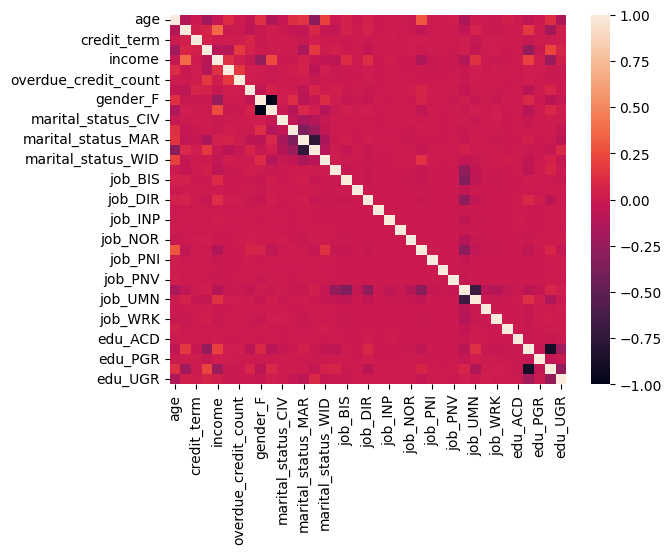

In [51]:
sns.heatmap(corr_matrix, annot=False);

Разделим сет на тренировочную и тестовую выборки в отношении 70/30 соответсвенно. Деление выполним с помощью библиотеки sklearn. Указанные параметры указывают на то, что размер тестовой выборки будет составлять 30 %, а повторное деление сета даст тот же результат, что и при первом запуске. Далее показатель random_state можно удалить и тогда деление будет осуществляться каим-то новым образом.

In [42]:
train, test = train_test_split(data, test_size=0.3, random_state = 1)

Для дальнейшей работы обновим список индекссов.

In [43]:
train.set_index(np.arange(len(train)), inplace=True)
test.set_index(np.arange(len(test)), inplace=True)

Выполним нормализацию сетов по некатегориальным значениям. Для этого разделим сет на две части.

In [44]:
"""st_columns = ["age", "sum_of_credit", "credit_term", "income", "credit_count", "overdue_credit_count"]

no_st_columns = list(data.columns)
for _ in st_columns:
    no_st_columns.remove(_)

train_st_copy = train[st_columns].copy()
test_st_copy = test[st_columns].copy()

train_no_st_st_copy = train[no_st_columns].copy()
test_no_st_copy = test[no_st_columns].copy()

scaler = StandardScaler()

d = scaler.fit_transform(train_st_copy)
train_st_copy = pd.DataFrame(d, columns = st_columns)

d = scaler.fit_transform(test_st_copy)
test_st_copy = pd.DataFrame(d, columns = st_columns)"""

'st_columns = ["age", "sum_of_credit", "credit_term", "income", "credit_count", "overdue_credit_count"]\n\nno_st_columns = list(data.columns)\nfor _ in st_columns:\n    no_st_columns.remove(_)\n\ntrain_st_copy = train[st_columns].copy()\ntest_st_copy = test[st_columns].copy()\n\ntrain_no_st_st_copy = train[no_st_columns].copy()\ntest_no_st_copy = test[no_st_columns].copy()\n\nscaler = StandardScaler()\n\nd = scaler.fit_transform(train_st_copy)\ntrain_st_copy = pd.DataFrame(d, columns = st_columns)\n\nd = scaler.fit_transform(test_st_copy)\ntest_st_copy = pd.DataFrame(d, columns = st_columns)'

"Склеим" обратно нормализованную и категориальные части сета между собой.

In [45]:
"""train_st = pd.concat([train_st_copy, train[no_st_columns]], axis=1)
test_st  = pd.concat([test_st_copy, test[no_st_columns]], axis=1)"""

'train_st = pd.concat([train_st_copy, train[no_st_columns]], axis=1)\ntest_st  = pd.concat([test_st_copy, test[no_st_columns]], axis=1)'

Выделим из сетов колонки с "аргуменами" и "функцией".

In [46]:
"""y_train, x_train = train_st["flag"], train_st.drop(["flag"], axis=1)
y_test, x_test = test_st["flag"], test_st.drop(["flag"], axis=1)"""

'y_train, x_train = train_st["flag"], train_st.drop(["flag"], axis=1)\ny_test, x_test = test_st["flag"], test_st.drop(["flag"], axis=1)'

Закомментировать, раскомментировать. Убирает номализацию.

In [47]:
y_train, x_train = train["flag"], train.drop(["flag"], axis=1)
y_test, x_test = test["flag"], test.drop(["flag"], axis=1)

Натренируем случайный лес.

In [48]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 10,  max_depth=5,  random_state=21)
rfc.fit(x_train, y_train)
rfc.score (x_test, y_test)

0.8391925661741514

Выполним AUC оценку.

In [49]:
y_pred = rfc.predict_proba(x_test)[:, 1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7288444035763302